In [1]:
# https://www.kaggle.com/code/rhodiumbeng/classifying-multi-label-comments-0-9741-lb
# https://github.com/PyThaiNLP/prachathai-67k/blob/master/classification.ipynb

In [ ]:
# https://www.youtube.com/watch?v=WLwjvWq0GWA

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import re
from pythainlp.util import normalize
from pythainlp import thai_characters
from pythainlp.corpus import thai_stopwords
from pythainlp.tokenize import word_tokenize

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

In [69]:
import pickle

# 1. Load data

In [8]:
df = pd.read_csv('prachathai-67k.csv')

In [9]:
df.head(5)

,url,date,title,body_text,labels
0,https://prachatai.com/print/42,2004-08-24 14:31,"นักวิจัยหนุน ""แม้ว"" เปิด ""จีเอ็มโอ""",ประชาไท --- 23 ส.ค.2547 นักวิจัยฯ ชี้นโยบายจี...,"['ข่าว', 'สิ่งแวดล้อม']"
1,https://prachatai.com/print/41,2004-08-24 14:22,ภาคประชาชนต้านเปิดเสรีจีเอ็มโอ,ประชาไท- 23 ส.ค.2547 นักวิชาการ ภาคประชาชน จ...,"['ข่าว', 'สิ่งแวดล้อม']"
2,https://prachatai.com/print/43,2004-08-24 15:17,จุฬาฯ ห่วงจีเอ็มโอลามข้าวไทย,นโยบายที่อนุญาตให้ปลูกร่วมกับพืชอื่นได้นั้นถื...,"['ข่าว', 'สิ่งแวดล้อม']"
3,https://prachatai.com/print/45,2004-08-24 15:58,ฟองสบู่การเมืองแตก ทักษิณหมดกึ๋น ชนชั้นกลางหมด...,ประชาไท -- 23 ส.ค. 47 ขาประจำทักษิณ ฟันธง ฟอง...,"['ข่าว', 'การเมือง', 'คณะเศรษฐศาสตร์ มหาวิทยาล..."
4,https://prachatai.com/print/47,2004-08-24 16:10,กอต.เสนอเลิกถนนคลองลาน-อุ้มผาง,ประชาไท-23 ส.ค.47 คณะกรรมการอนุรักษ์ ผืนป่าตะ...,"['ข่าว', 'สิ่งแวดล้อม']"


In [10]:
df.shape

(67889, 5)

# 2. Check data quality

data type

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67889 entries, 0 to 67888
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   url        67889 non-null  object
 1   date       67889 non-null  object
 2   title      67889 non-null  object
 3   body_text  67889 non-null  object
 4   labels     67889 non-null  object
dtypes: object(5)
memory usage: 2.6+ MB


unique value

In [12]:
for i in df.columns:
    print('Columns name: ', i)
    print('Unique value: ', df[i].unique())
    print('Count unique value: ', df[i].nunique())
    print('-'*10)

Columns name:  url
Unique value:  ['https://prachatai.com/print/42' 'https://prachatai.com/print/41'
 'https://prachatai.com/print/43' ... 'https://prachatai.com/print/79625'
 'https://prachatai.com/print/79628' 'https://prachatai.com/print/79629']
Count unique value:  67889
----------
Columns name:  date
Unique value:  ['2004-08-24 14:31' '2004-08-24 14:22' '2004-08-24 15:17' ...
 '2018-11-15 12:47' '2018-11-15 20:45' '2018-11-15 21:34']
Count unique value:  66732
----------
Columns name:  title
Unique value:  ['นักวิจัยหนุน  "แม้ว"  เปิด  "จีเอ็มโอ"' 'ภาคประชาชนต้านเปิดเสรีจีเอ็มโอ'
 'จุฬาฯ ห่วงจีเอ็มโอลามข้าวไทย' ...
 'ยุติวงจรผลัดกันเกาหลัง ด้วยการยื่นบัญชีทรัพย์สินฯ'
 'รัฐสวัสดิการ 101 กับ\xa0ภาคภูมิ แสงกนกกุล :\xa0การจัดวางความสัมพันธ์ใหม่ระหว่างรัฐ-สังคม'
 "ชาวอุยกูร์ในสหรัฐฯ ชุมนุมวันประกาศเอกราช เรียกร้องกดดันจีนกรณี 'ค่ายกักกัน'"]
Count unique value:  67417
----------
Columns name:  body_text
Unique value:  ['ประชาไท --- 23 ส.ค.2547  นักวิจัยฯ ชี้นโยบายจีเอ็มโอเอื้อต่อการค้นค

missing value

In [13]:
df.isna().sum()

url          0
date         0
title        0
body_text    0
labels       0
dtype: int64

pivot the label

In [14]:
benchmark_labels = ['การเมือง','สิทธิมนุษยชน','คุณภาพชีวิต','ต่างประเทศ','สังคม',
                  'สิ่งแวดล้อม','เศรษฐกิจ','วัฒนธรรม','แรงงาน','ความมั่นคง','ไอซีที','การศึกษา']

In [15]:
def expand_list_to_columns(row):
    classes = {c: int(c in row['labels']) for c in benchmark_labels}
    return pd.Series(classes)

In [16]:
new_cols = df.apply(expand_list_to_columns, axis=1)
df = pd.concat([df, new_cols], axis=1)

In [17]:
column_mapping = {
    "การเมือง": "politics",
    "สิทธิมนุษยชน": "human_rights",
    "คุณภาพชีวิต": "quality_of_life",
    "ต่างประเทศ": "foreign_affairs",
    "สังคม": "society",
    "สิ่งแวดล้อม": "environment",
    "เศรษฐกิจ": "economy",
    "วัฒนธรรม": "culture",
    "แรงงาน": "labor",
    "ความมั่นคง": "security",
    "ไอซีที": "ict",
    "การศึกษา": "education"
}

In [18]:
df = df.rename(columns=column_mapping)

merge title with body

In [19]:
df['full_body_text'] = df['title'] + df['body_text']

In [20]:
target_col = ['politics','human_rights','quality_of_life','foreign_affairs','society','environment','economy','culture','labor','security','ict','education']

In [21]:
df = df[['full_body_text'] + target_col]

# 3. Exploratory data analysis (EDA)

In [22]:
df[target_col].describe()

,politics,human_rights,quality_of_life,foreign_affairs,society,environment,economy,culture,labor,security,ict,education
count,67889.000000,67889.000000,67889.000000,67889.000000,67889.000000,67889.000000,67889.000000,67889.000000,67889.000000,67889.000000,67889.000000,67889.000000
mean,0.581125,0.223527,0.166654,0.121581,0.129992,0.114864,0.076434,0.065136,0.056725,0.055502,0.042805,0.039314
std,0.493378,0.416611,0.372670,0.326803,0.336297,0.318860,0.265693,0.246767,0.231318,0.228960,0.202419,0.194343
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
df[target_col].sum(axis=1).min()

0

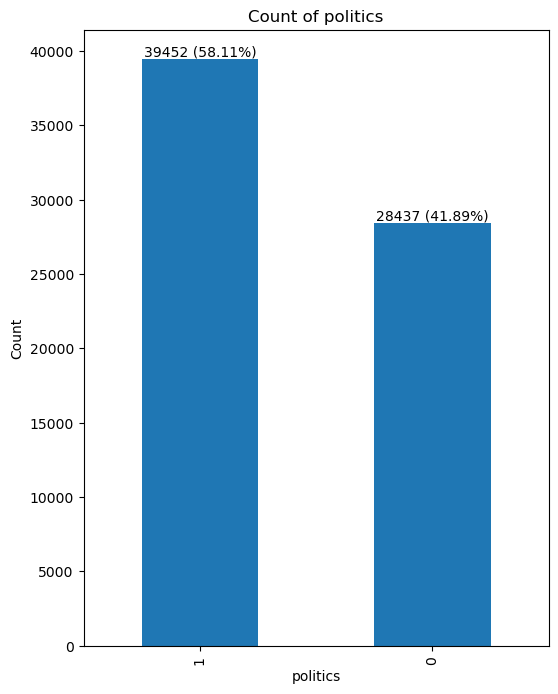

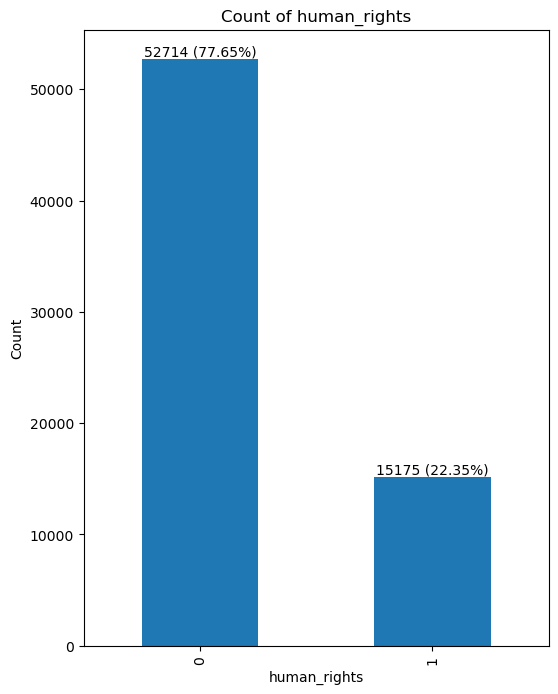

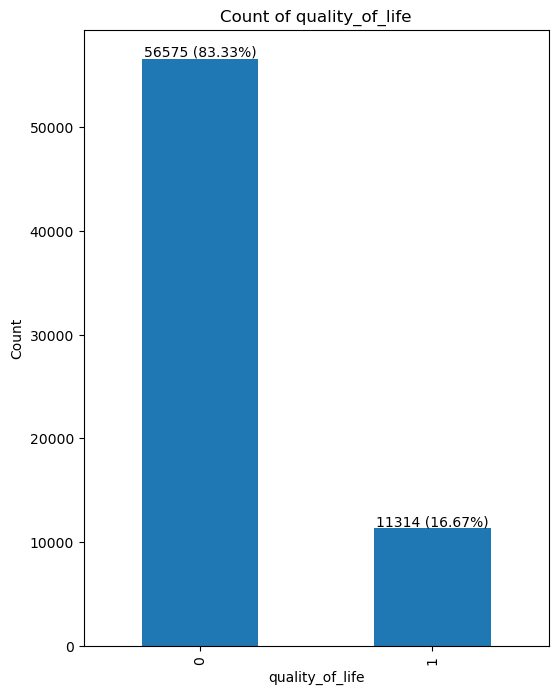

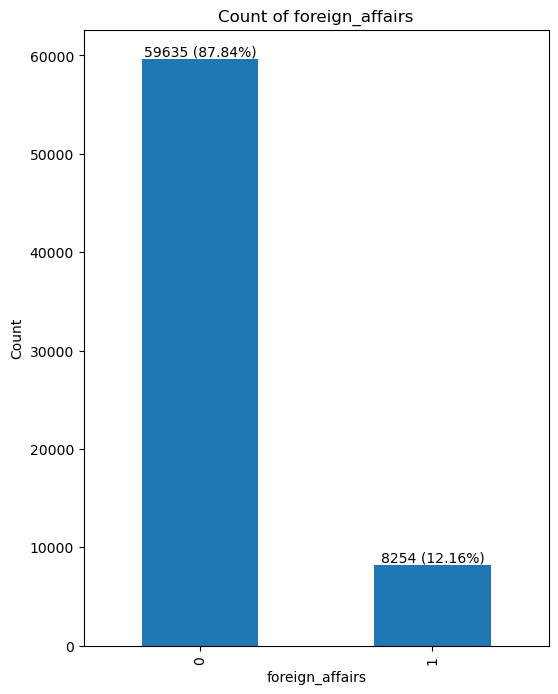

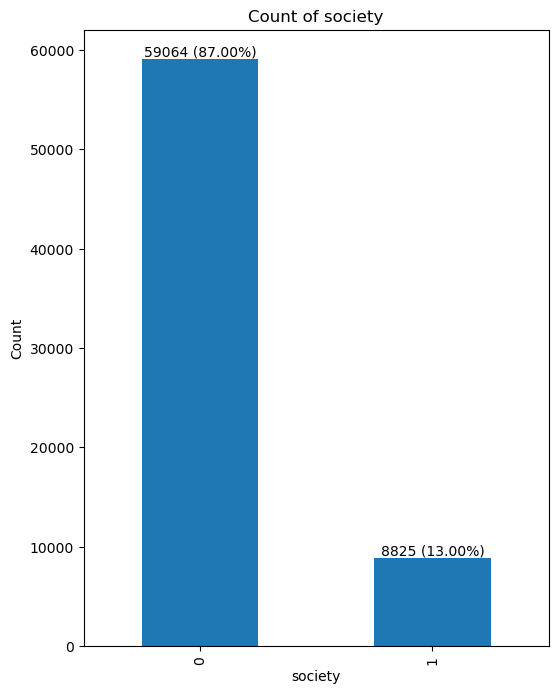

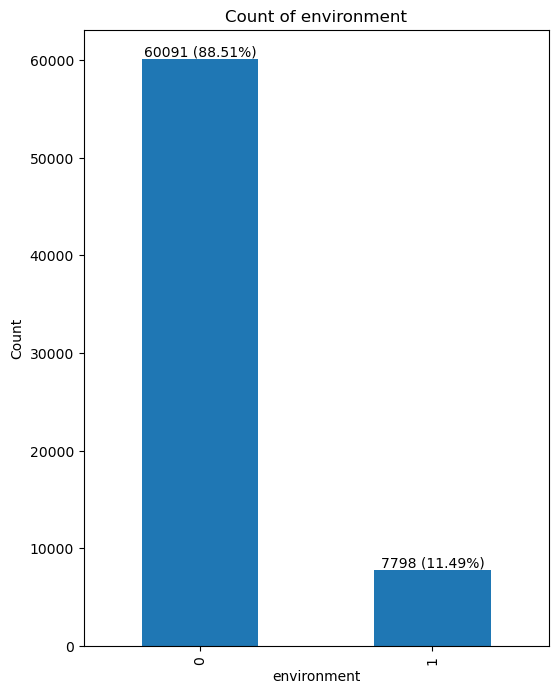

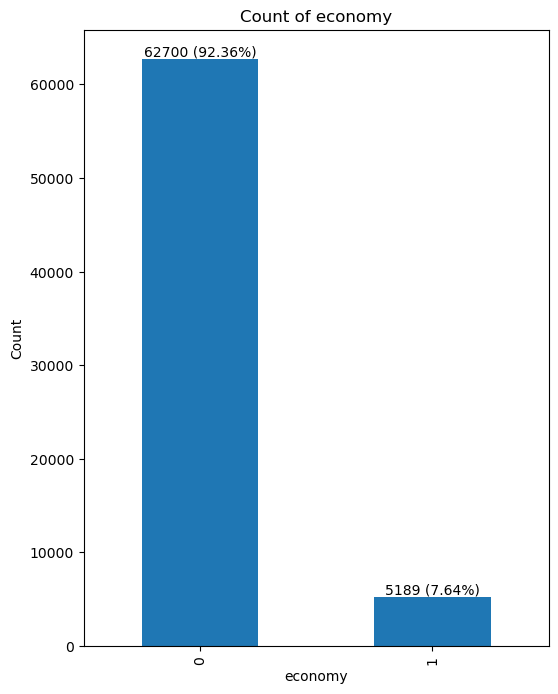

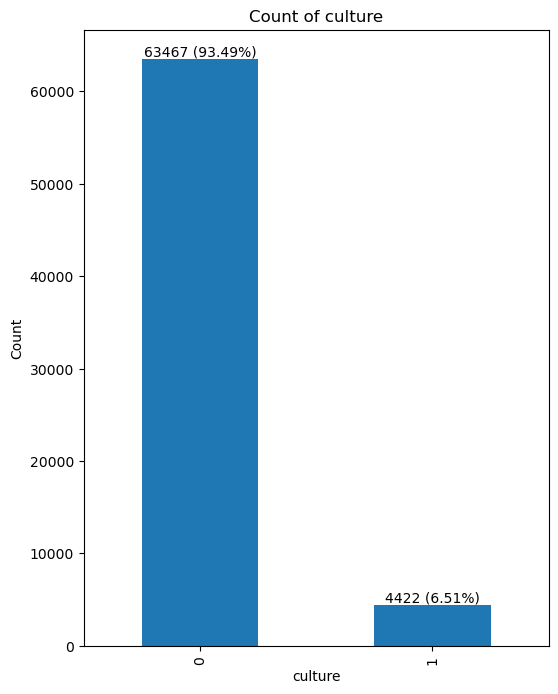

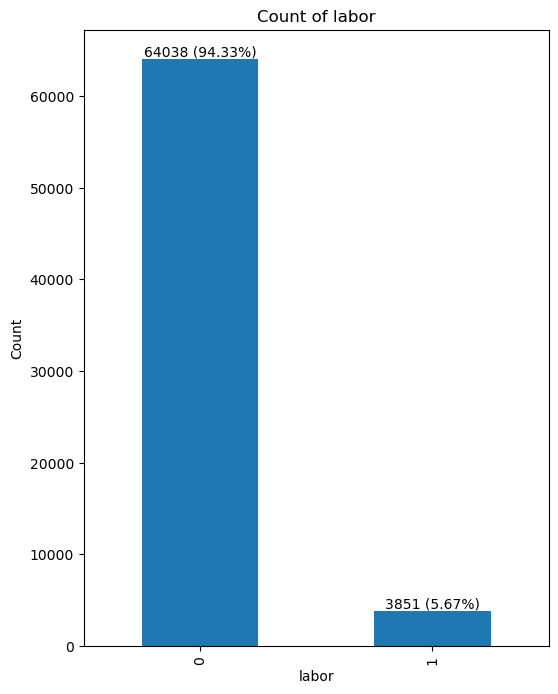

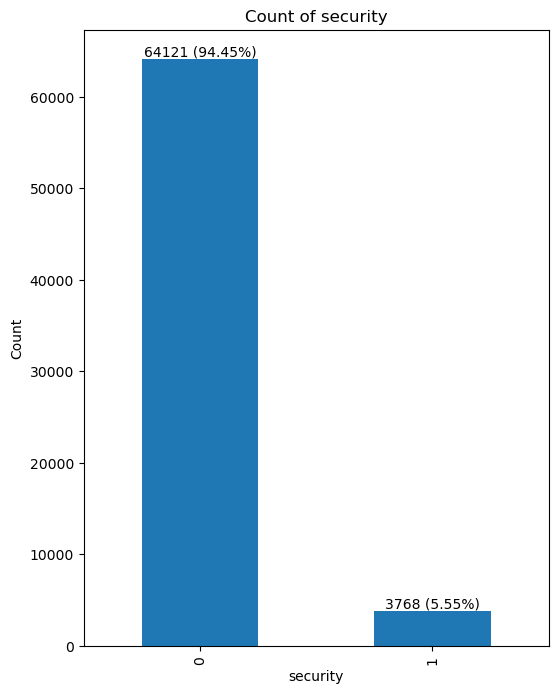

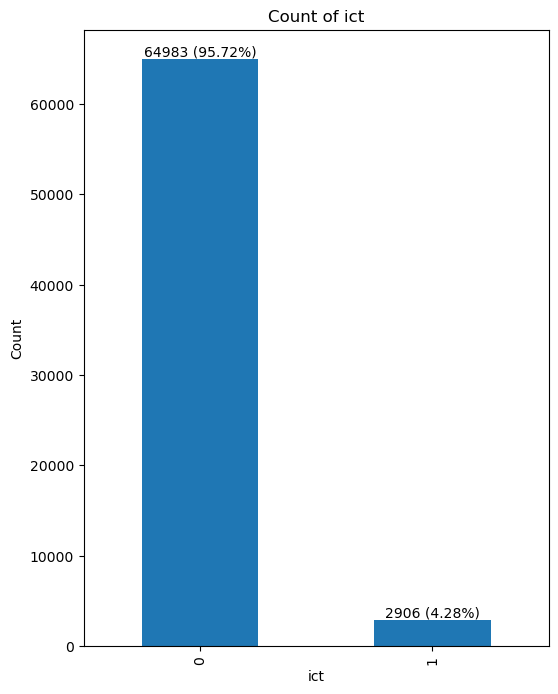

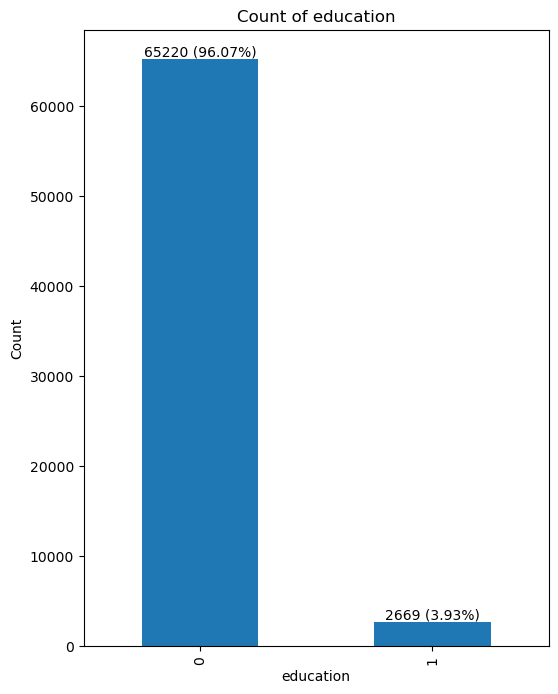

In [24]:
for column in target_col:
    category_counts = df[column].value_counts()
    total_count = len(df[column])
    plt.figure(figsize=(6, 8))
    ax = category_counts.plot(kind='bar')
    for i, count in enumerate(category_counts):
        percentage = (count / total_count) * 100
        ax.annotate(f'{count} ({percentage:.2f}%)', xy=(i, count), ha='center', va='bottom')
    
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Count of {column}')
    plt.show()

In [25]:
# All the class facing with imbalance problem.

In [26]:
target_col

['politics',
 'human_rights',
 'quality_of_life',
 'foreign_affairs',
 'society',
 'environment',
 'economy',
 'culture',
 'labor',
 'security',
 'ict',
 'education']

In [27]:
target_corr = df[target_col].corr()

<Axes: >

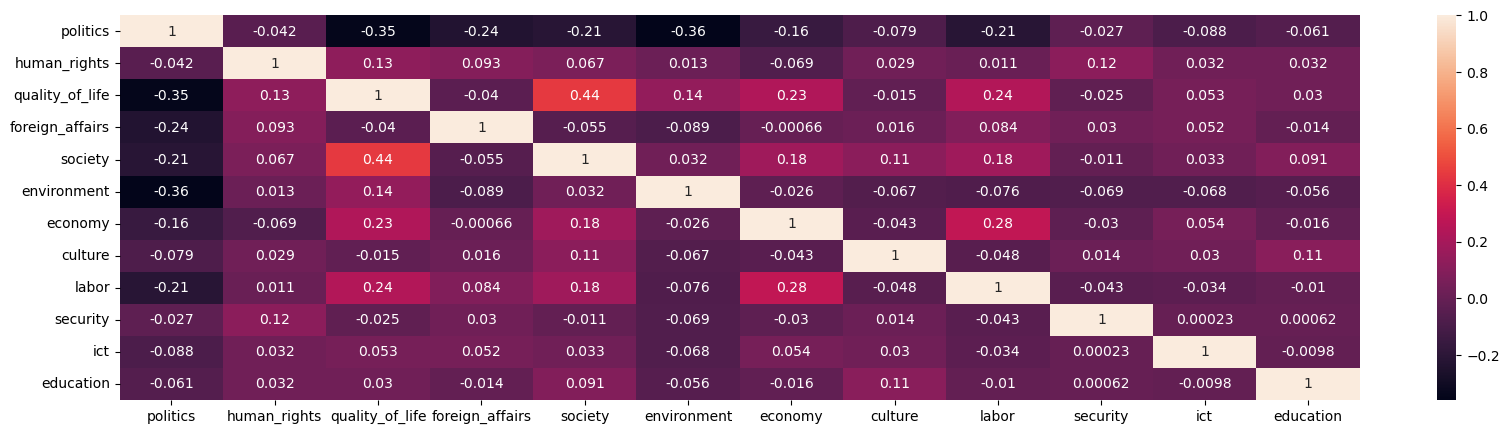

In [28]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(target_corr, annot=True, ax=ax)

In [29]:
# All the labels are not correlate much
# So we can use binary relevance

# 4. Clean data

In [30]:
def normalize_text(text):
    return normalize(text)

In [31]:
def remove_html_tags(text):
    return re.sub(r'<[^>]+>', '', text)

In [32]:
def remove_urls(text):
    URL_PATTERN = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
    return re.sub(URL_PATTERN, '', text)

In [33]:
def remove_non_thai_characters(text):
    allowed_characters = thai_characters
    escaped_allowed_characters = re.escape(allowed_characters)
    pattern = '[^' + escaped_allowed_characters + ']'
    return re.sub(pattern, '', text)

In [34]:
def remove_stopwords(text):
    stopwords = thai_stopwords()
    text_tokens = text.split()
    text_tokens = [word for word in text_tokens if word not in stopwords]
    return ''.join(text_tokens)

In [35]:
def remove_special_characters(text):
    pattern = r'[!@#$%^&*()\-+=\[\]{};:\'",<.>/?\\|]\n'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

In [36]:
def remove_words_from_text(text):
    words_to_remove = ['ประชาไท','ฯ','๑','๒','๓','๔','๕','๖','๗','๘','๙','๐']
    for word in words_to_remove:
        text = text.replace(word, '')
    return text

In [37]:
def remove_extra_spaces(text):
    return re.sub(r'\s+', '', text).strip()

In [38]:
def preprocess_text(text):
    text = normalize_text(text)
    text = remove_html_tags(text)
    text = remove_urls(text)
    text = remove_non_thai_characters(text)
    text = remove_stopwords(text)
    text = remove_special_characters(text)
    text = remove_words_from_text(text)
    text = remove_extra_spaces(text)
    return word_tokenize(text, engine='newmm')

# 4. Model

In [39]:
df.sample(20)

,full_body_text,politics,human_rights,quality_of_life,foreign_affairs,society,environment,economy,culture,labor,security,ict,education
54846,ร่างรัฐธรรมนูญ 59 หนุนเผยแผ่พุทธเถรวาท-เพิ่มกล...,0,0,0,0,1,0,0,1,0,0,0,0
55073,คตง.จ่อพิจารณาไฟประดับ กทม.เอื้อประโยชน์เอกชนค...,1,0,0,0,0,0,0,0,0,0,0,0
54609,กรธ.หวังมีปาฏิหาริย์ให้ปชช.ยอมรับร่างรธน. เผยข...,1,0,0,0,0,0,0,0,0,0,0,0
8131,"บทความ ดร. เจิมศักดิ์: ขอให้ ""ยุบพรรคไทยรักไทย...",1,0,0,0,0,0,0,0,0,0,0,0
40870,ตัวแทนสวนยางเจรจา รมว.เกษตรฯ รับราคา 80 บ/ก.ก....,1,0,0,0,0,0,1,0,0,0,0,0
51893,แกนนำพรรคขวาจัดในฝรั่งเศสถูกดำเนินคดีหลังปราศร...,0,0,0,1,0,0,0,0,0,0,0,0
22,วุฒิฯ บล็อกโหวตเลือก 7 กทช. ส.ว.อุบลราชธานีแฉ...,0,0,0,0,0,1,0,0,0,0,0,0
19675,การศึกษาของแรงงานข้ามชาติ เรื่องที่อาเซียนยังไ...,1,0,0,0,0,0,0,0,0,0,0,0
67357,ช่วงเย็นคนยังทยอยนำดอกไม้มารำลึก 42 ปี 6 ตุลาฯ...,1,1,0,0,0,0,0,0,0,0,0,0
31175,คลิป: กลุ่มหนุนปฏิรูปเลือกตั้งชุมนุมหลายจุดในก...,0,0,0,1,0,0,0,0,0,0,0,0


In [40]:
target_col = ['politics','human_rights','quality_of_life','foreign_affairs','society','environment','economy','culture','labor','security','ict','education']

Train test split

In [41]:
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

In [42]:
for i in range(0,len(target_col),1):
    print(target_col[i])
    X_train, X_test, y_train, y_test = train_test_split(df['full_body_text'], df[target_col[i]], test_size=0.2, random_state=42)

    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

politics
human_rights
quality_of_life
foreign_affairs
society
environment
economy
culture
labor
security
ict
education


TD-IDF

In [43]:
X_train_tfidf_list = []
X_test_tfidf_list = []
tfidf_model_list = []

In [44]:
for i in range(0, len(target_col), 1):
    print(target_col[i])
    
    tfidf_vectorizer = TfidfVectorizer(analyzer=preprocess_text, max_features=2000)
    X_train = tfidf_vectorizer.fit_transform(X_train_list[i])
    X_test = tfidf_vectorizer.transform(X_test_list[i])

    X_train_tfidf_list.append(X_train)
    X_test_tfidf_list.append(X_test)
    tfidf_model_list.append(tfidf_vectorizer)

politics
human_rights
quality_of_life
foreign_affairs
society
environment
economy
culture
labor
security
ict
education


Model

In [53]:
models = {}
metrics = {}

In [54]:
for i in range(0, len(target_col), 1):
    print(target_col[i])
    
    model = LogisticRegression(solver='lbfgs', max_iter=5000)
    model.fit(X_train_tfidf_list[i], y_train_list[i])
    
    # Store the model
    models[target_col[i]] = model
    
    # Predictions
    y_pred = model.predict(X_test_tfidf_list[i])
    y_proba = model.predict_proba(X_test_tfidf_list[i])[:, 1]
    
    # Evaluation
    accuracy = accuracy_score(y_test_list[i], y_pred)
    precision = precision_score(y_test_list[i], y_pred)
    recall = recall_score(y_test_list[i], y_pred)
    aucroc = roc_auc_score(y_test_list[i], y_proba)
    metrics[target_col[i]] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'aucroc': aucroc}

politics
human_rights
quality_of_life
foreign_affairs
society
environment
economy
culture
labor
security
ict
education


Evaluation

In [55]:
metrics_df = pd.DataFrame.from_dict(metrics, orient='index')

In [56]:
metrics_df

,accuracy,precision,recall,aucroc
politics,0.769480,0.807687,0.791503,0.849225
human_rights,0.852187,0.755081,0.493524,0.876086
quality_of_life,0.874282,0.712878,0.438149,0.880265
foreign_affairs,0.935116,0.813364,0.624042,0.956705
society,0.875976,0.649746,0.142064,0.805175
environment,0.917219,0.728166,0.432555,0.926447
economy,0.937251,0.702564,0.377410,0.920809
culture,0.944616,0.705747,0.329753,0.931127
labor,0.972308,0.826797,0.652062,0.975927
security,0.953749,0.770492,0.247368,0.900199


# 5. Save model

vectorization model

In [84]:
tfidf_model_list

[TfidfVectorizer(analyzer=<function preprocess_text at 0x000001E690F30CC0>,
                 max_features=2000),
 TfidfVectorizer(analyzer=<function preprocess_text at 0x000001E690F30CC0>,
                 max_features=2000),
 TfidfVectorizer(analyzer=<function preprocess_text at 0x000001E690F30CC0>,
                 max_features=2000),
 TfidfVectorizer(analyzer=<function preprocess_text at 0x000001E690F30CC0>,
                 max_features=2000),
 TfidfVectorizer(analyzer=<function preprocess_text at 0x000001E690F30CC0>,
                 max_features=2000),
 TfidfVectorizer(analyzer=<function preprocess_text at 0x000001E690F30CC0>,
                 max_features=2000),
 TfidfVectorizer(analyzer=<function preprocess_text at 0x000001E690F30CC0>,
                 max_features=2000),
 TfidfVectorizer(analyzer=<function preprocess_text at 0x000001E690F30CC0>,
                 max_features=2000),
 TfidfVectorizer(analyzer=<function preprocess_text at 0x000001E690F30CC0>,
                 max

In [85]:
for i in range(len(target_col)):
    print(target_col[i])
    filepath = f'./vectorization model pickle/{target_col[i]}_vectorization.pickle'
    with open(filepath, 'wb') as file:
        pickle.dump(tfidf_model_list[i], file)

politics
human_rights
quality_of_life
foreign_affairs
society
environment
economy
culture
labor
security
ict
education


prediciton model

In [86]:
models

{'politics': LogisticRegression(max_iter=5000),
 'human_rights': LogisticRegression(max_iter=5000),
 'quality_of_life': LogisticRegression(max_iter=5000),
 'foreign_affairs': LogisticRegression(max_iter=5000),
 'society': LogisticRegression(max_iter=5000),
 'environment': LogisticRegression(max_iter=5000),
 'economy': LogisticRegression(max_iter=5000),
 'culture': LogisticRegression(max_iter=5000),
 'labor': LogisticRegression(max_iter=5000),
 'security': LogisticRegression(max_iter=5000),
 'ict': LogisticRegression(max_iter=5000),
 'education': LogisticRegression(max_iter=5000)}

In [87]:
for i in range(len(target_col)):
    print(target_col[i])
    filepath = f'./prediction model pickle/{target_col[i]}_prediction.pickle'
    with open(filepath, 'wb') as file:
        pickle.dump(models[target_col[i]], file)

politics
human_rights
quality_of_life
foreign_affairs
society
environment
economy
culture
labor
security
ict
education


# 6. Prediction

In [127]:
vectorization_model = pickle.load(open('vectorization model pickle/politics_vectorization.pickle', 'rb'))

In [128]:
prediction_model = pickle.load(open('prediction model pickle/politics_prediction.pickle', 'rb'))

In [129]:
title_input = """อ่านเกมการเมือง หลัง “ทักษิณ” พักโทษ สภาวะ 3 นายก!"""

In [130]:
body_input = """
โดย PPTV Online เผยแพร่ 18 ก.พ. 2567 ,18:08น.
นักวิชาการอ่านเกมการเมือง หลัง “ทักษิณ ชินวัตร” ได้รับการพักโทษ เชื่อเพื่อไทยทำงานง่ายขึ้น – แต่ต้องตกอยู่ในสภาวะ 3 นายกฯ จากกรณีนายทักษิณ ชินวัตร
อดีตนายกรัฐมนตรี ได้รับการพักโทษและเดินทางออกจากโรงพยาบาลตำรวจเมื่อช่วงเช้าตรู่ที่ผ่านมานั้น ซึ่งหลังจากนายทักษิณ ได้รับการพักโทษ
ทำให้นักวิชาการหลายคนมีการออกมาวิเคราะห์ทิศทางการเมืองหลังจากนี้ โดยหนึ่งในนั้นคือ รศ.ดร.ธนพร ศรียากูล ผู้อำนวยการสถาบันวิเคราะห์การเมืองและนโยบาย
ซึ่งประเมินสถานการณ์การเมืองหลังจากนี้ ว่า เมื่อ อดีตนายกฯทักษิณ ได้รับการพักโทษ ออกจากโรงพยาบาล กลับไปพักที่บ้านจันทร์ส่องหล้า จะยิ่งเป็นการเสริมความแข็งแรงให้กับพรรคเพื่อไทยและรัฐบาลมากยิ่งขึ้น

และมองว่าหลังจากนี้นายเศรษฐา ทวีสิน นายกรัฐมนตรี และรัฐมนตรีว่าการกระทรวงการคลัง จะขับเคลื่อนนโยบายใด ก็จะทำง่ายขึ้น เพราะจะมีนายทักษิณคอยช่วยคิด  และคอยอำนวยความสะดวกในการทำงาน
ผู้สื่อข่าวถามว่า แบบนี้ จะกลายเป็นว่า มีนายกรัฐมนตรี ถึง 2 คนหรือไม่ เพราะมีนายทักษิณ มาคอยช่วยคิดงานให้นายเศรษฐา ซึ่ง รศ.ดร.ธนพร มองว่า ตอนนี้ ประเทศไทย มีนายกฯ ถึง 3 คน คือ นายเศรษฐา,
น.ส.แพทองธาร ชินวัตร และ นายทักษิณ ชินวัตร เพราะวันนี้นายเศรษฐา ยังตอบผู้สื่อข่าวไม่ชัดเลย ว่ามีนายกฯ กี่คน ตอบแค่เพียงว่า เป็นนายกฯตามรัฐธรรมนูญ แต่นายเศรษฐา ไม่ได้ตอบว่านายกฯ นอกรัฐธรรมนูญ มีใครอีกบ้าง
ส่วนประเด็นที่ปรากฎภาพของ นายทักษิณ ออกจากโรงพยาบาลในวันนี้ ภาพที่ประชาชน ได้เห็นใส่เฝือกที่แขน และเฝือกอ่อนที่คอ เป็นอาการป่วยที่เกิดขึ้นระหว่างรักษาตัว หรือถูกจัดฉากขึ้นมา ให้ดูเหมือนป่วย เพราะก่อนหน้านี้
ไม่มีใครทราบข่าวว่า นายทักษิณ แขนหัก หรือ กระดูกคอ เป็นอะไรนั้น รศ.ดร.ธนพร มองว่า การที่มีภาพนายทักษิณ ดามเฝือก ใส่เสื้อสีมงคล มีการกำหนดเวลาฤกษ์ออกจาก รพ. เหล่านี้ เป็นการที่พรรคเพื่อไทย
ต้องการสร้างสีสัน เพื่อต้อนรับนายใหญ่กลับบ้าน อย่างเป็นทางการ และถือเป็นการช่วงชิงพื้นที่สื่อ ให้นายทักษิณ มีพื้นที่ในสื่อในช่วงตลอดสัปดาห์นี้ อย่างไรก็ตาม รศ.ดร.ธนพร ย้ำว่า การออกมาของ นายทักษิณ
จะทำให้ฝากฝั่งรัฐบาล ทำงานง่ายขึ้น ไม่ใช่เพียงแต่ นายเศรษฐา นายกรัฐมนตรีเท่านั้น  แต่อุ๊งอิ๊งค์เอง ก็ทำงานได้คล่องขึ้น เนื่องจากนี่คือพี่ใหญ่ตัวจริงที่ไม่มีใครกล้าขวาง
"""

In [131]:
all_input = title_input + body_input

In [132]:
input_vector = vectorization_model.transform([all_input])

In [133]:
prediction = prediction_model.predict(input_vector)

In [135]:
if prediction[0] == 1:
    print('Politics news')
else:
    print('Not politics news')

Politics news
